In [1]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

In [2]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

# Original Series

In [3]:
ts = pd.read_csv('video visits.csv')
ts.index = np.arange(1,len(ts)+1)

Text(0, 0.5, 'Views')

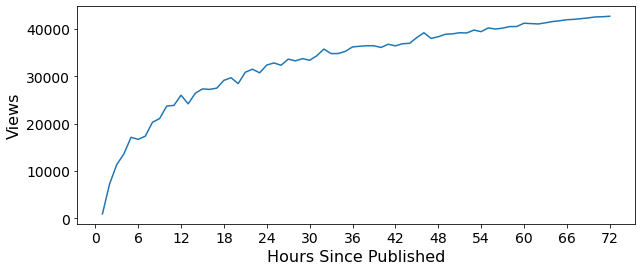

In [4]:
plt.figure(figsize=(10,4))
plt.plot(ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(0,50000,10000), fontsize=14)
plt.ylabel('Views', fontsize=16)

# Transformation

## <font color='blue'>Original series: $v_t$</font>

### (1) Normalize $(v_t$ &#8594; $n_t): n_t = \frac{v_t - μ}{σ}$

### (2) Exponentiate $(n_t$ &#8594; $e_t): e_t = e^{n_t}$

### (3) First difference $(e_t$ &#8594; $d_t): d_t = e_t - e_{t-1}$

## <font color='blue'>Transformed series: $d_t = e^{\frac{v_t - μ}{σ}} - e^{\frac{v_{t-1} - μ}{σ}}$</font>

# (1) Normalize

In [5]:
mu = np.mean(ts).iloc[0]
sigma = np.std(ts).iloc[0]

norm_ts = (ts - mu) / sigma

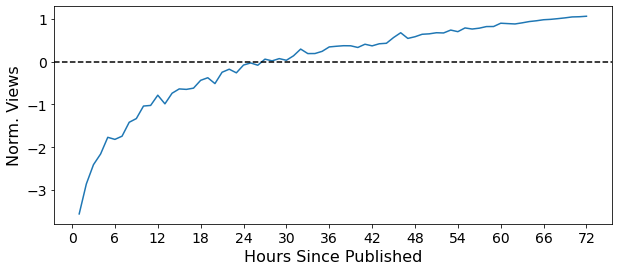

In [6]:
plt.figure(figsize=(10,4))
plt.plot(norm_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-3,2), fontsize=14)
plt.ylabel('Norm. Views', fontsize=16)

plt.axhline(0, color='k', linestyle='--')

In [31]:
exp_ts = np.exp(norm_ts)

Text(0, 0.5, 'Exp. Norm. Views')

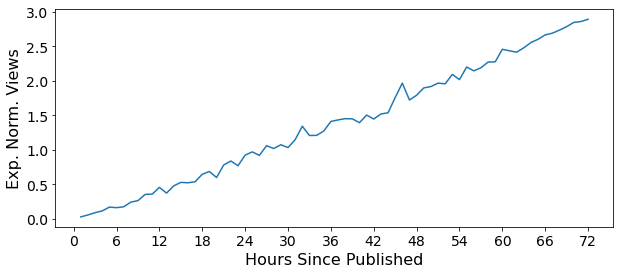

In [32]:
plt.figure(figsize=(10,4))
plt.plot(exp_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(0,3.5,.5), fontsize=14)
plt.ylabel('Exp. Norm. Views', fontsize=16)

# (3) First Difference

In [9]:
diff_ts = exp_ts.diff().dropna()

Text(0, 0.5, 'First Diff. \nExp. Norm. Views')

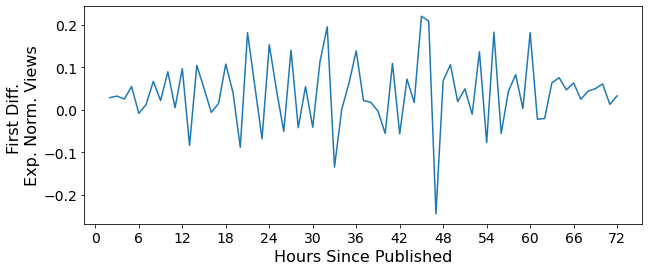

In [10]:
plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-0.2,0.3,.1), fontsize=14)
plt.ylabel('First Diff. \nExp. Norm. Views', fontsize=16)

In [11]:
perform_adf_test(diff_ts)

ADF Statistic: -4.881064
p-value: 0.000038


# Fit ARMA Model

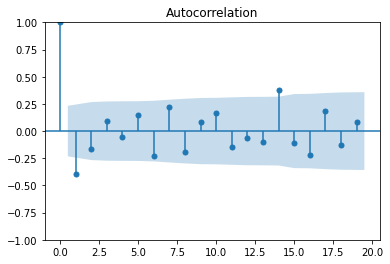

In [12]:
plot_acf(diff_ts)
plt.show()

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


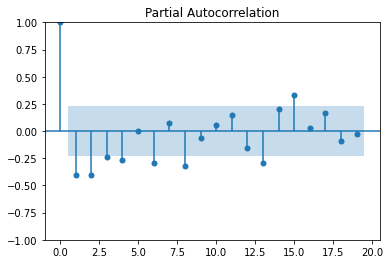

In [13]:
plot_pacf(diff_ts)
plt.show()

In [14]:
#create the model
model = ARIMA(diff_ts, order=(4,0,1))

# fit the model
model_fit = model.fit()

prediction = pd.Series(model_fit.forecast(3))

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


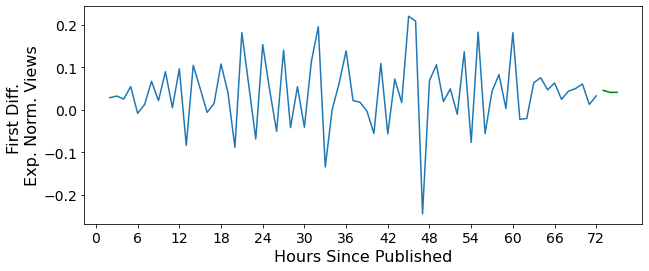

In [15]:
plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-0.2,0.3,.1), fontsize=14)
plt.ylabel('First Diff. \nExp. Norm. Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), prediction, color='g')

# <font color='blue'> Undo Transformations: $\hat{d}_{t+1}$ &#8594; $\hat{v}_{t+1}$</font>

## &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; <font color='blue'> $\hat{v}_{t+1} = σ \ln (\hat{d}_{t+1} + e^{\frac{v_t - μ}{σ}}) + μ$</font>

In [16]:
def undo_transformations(predictions, series, mu, sigma):
    first_pred = sigma*np.log(predictions[0] + np.exp((series.iloc[-1]-mu)/sigma)) + mu
    orig_predictions = [first_pred]
    
    for i in range(len(predictions[1:])):
        next_pred = sigma*np.log(predictions[i+1] + np.exp((orig_predictions[-1]-mu)/sigma)) + mu
        orig_predictions.append(next_pred)
    
    return np.array(orig_predictions).flatten()

In [17]:
orig_preds = undo_transformations(prediction.to_numpy(), ts, mu, sigma)

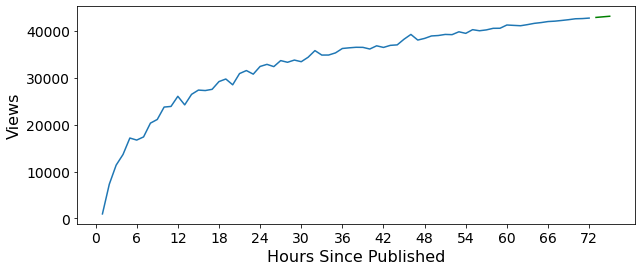

In [18]:
plt.figure(figsize=(10,4))
plt.plot(ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(0,50000,10000), fontsize=14)
plt.ylabel('Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), orig_preds, color='g')

(40000.0, 45000.0)

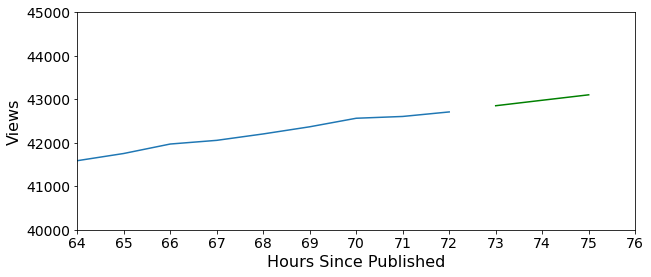

In [19]:
plt.figure(figsize=(10,4))
plt.plot(ts)

plt.xticks(np.arange(0,78), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(40000,46000,1000), fontsize=14)
plt.ylabel('Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), orig_preds, color='g')
plt.xlim(64,76)
plt.ylim(40000, 45000)